Shuai Zhao

# 2. Create data : 100 train 50 val

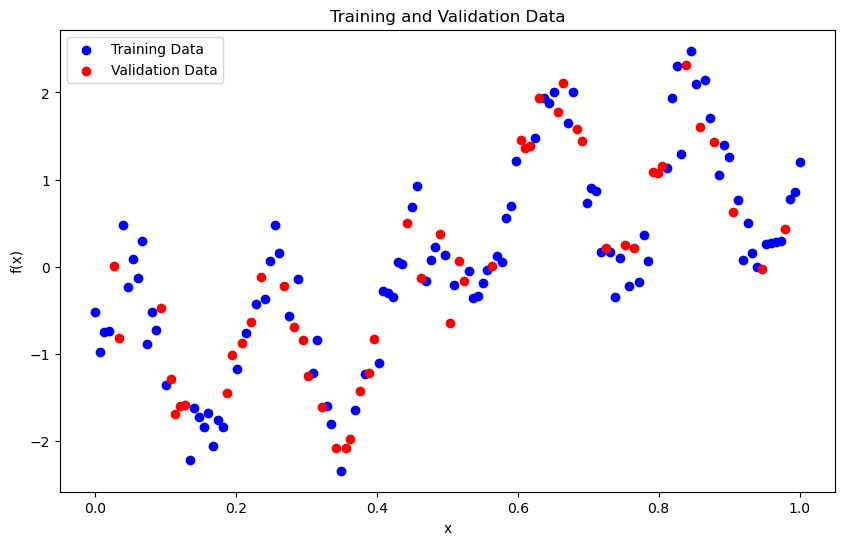

# train set: 100
# val set: 50


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# set seed to 1
np.random.seed(1)

# target function
def target_function(x):
    noise = np.random.normal(0, 1, x.shape)
    return np.tanh(20 * (x - 0.5)) + np.sin(10 * np.pi * x) + 0.3 * noise

# 150 pts
x = np.linspace(0, 1, 150)
y = target_function(x)

# split the points into train_set and val_set
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.333, random_state=1)

# sort by x
train_sorted_indices = np.argsort(x_train)
val_sorted_indices = np.argsort(x_val)

x_train_sorted, y_train_sorted = x_train[train_sorted_indices], y_train[train_sorted_indices]
x_val_sorted, y_val_sorted = x_val[val_sorted_indices], y_val[val_sorted_indices]


# plot train and val data
plt.figure(figsize=(10, 6))
plt.scatter(x_train_sorted, y_train_sorted, color='blue', label='Training Data')
plt.scatter(x_val_sorted, y_val_sorted, color='red', label='Validation Data')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Training and Validation Data')

plt.legend()
plt.show()

# print numbers to make sure
print(f"# train set: {len(x_train_sorted)}")
print(f"# val set: {len(x_val_sorted)}")

# 3. Class CustomDataset

In [5]:
import torch
from torch.utils.data import DataLoader

# Create a custom dataset class 
class CustomDataset(DataLoader):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# 4. set minibatch(size50, shuffling) 

In [7]:
# Use the above class to create datasets
train_dataset = CustomDataset(x_train_sorted, y_train_sorted)
val_dataset = CustomDataset(x_val, y_val)

# use DataLoader
batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# number of mini-batches
num_batches = len(train_loader)
print(f"Mini-batches 的数量: {num_batches}")


Mini-batches 的数量: 2


## How many mini-batches would this lead to?
100/50=2
so we have 2 mini-batches

## why you need to create mini-batches only for the training data and not the validation data
1. why use?
   To reduce the time that we updata the parameters.
   Since we have 100 training data, we should update parameters for 100 times.
   However when we divide the data into 2 batches, we only need to update the parameters twice.
   This will save time and memory.

2. why not to val data?
   We don't update parameters in val process.
   Also, we'd like to validate by using the whole val_set in each epoch, so we don't need batches

# 5. define MLP and parameters
training part will be shown in 6.(a)

In [15]:
import torch
import torch.nn as nn  
import torch.optim as optim

# MLP class
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, width, depth, activation):
        super(MLP, self).__init__()

        # Input layer
        MLP_list = [nn.Linear(input_dim, width)]

        # Hidden layers
        for i in range(depth - 1):
            MLP_list.append(nn.Linear(width, width))

        # Output layer (without activation function)
        MLP_list.append(nn.Linear(width, output_dim))

        # Construct network
        self.model = nn.ModuleList(MLP_list)

        # Activation
        self.activation_name = activation
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sin':
            self.activation = lambda x: torch.sin(x)

        # Method to initialize weights
        def init_weights(layer):
            if isinstance(layer, nn.Linear):
                nn.init.uniform_(layer.weight, -1, 1)

            for layer in self.model:
                if hasattr(layer, 'bias') and layer.bias is not None:
                    nn.init.uniform_(layer.bias, -1, 1)

        # Initialize weights and biases
        self.model.apply(init_weights)

    # Forward
    def forward(self, x):
        x = x.unsqueeze(1) # add a dimension to the input
        for layer in self.model[:-1]:  # Apply activation to all layers except the last one
            x = self.activation(layer(x))
        x = self.model[-1](x)  # Last layer without activation
        return x

# hyperparameters
input_dim = 1
output_dim = 1
width = 45
depth = 8
learning_rate = 1e-3

# regularization parameters
regularization_params = [0.0, 1e-3, 1e-2, 1e-1]

# num of epochs
num_epochs = 10000

# 6.(a) training, saving the history of train_MSE & val_MSE

In [17]:
import matplotlib.pyplot as plt
from tqdm import tqdm  

# MSE history
train_mse_history = {reg: [] for reg in regularization_params}
val_mse_history = {reg: [] for reg in regularization_params}

# use nn.MSELoss() as loss function
loss_function = nn.MSELoss()

# preditions results (will be used in 6.(c) for plotting)
predictions_history = []
test_points = torch.linspace(0, 1, steps=1000).unsqueeze(1) 

# loops for each reg_param
for reg_idx, reg_param in enumerate(regularization_params):  
    print(f"Training with regularization parameter: {reg_param}")
    train_mse_per_run = []
    val_mse_per_run = []

    # predict results for this reg_params
    current_reg_predictions = []

    # each reg_param will run 4 times
    for run in range(4): 
        print(f"Run {run+1} for regularization parameter: {reg_param}")

        # MLP model
        model = MLP(input_dim, output_dim, width, depth, 'sin')
        # Adam with learning rate = 1e-3 and weight_decay = regularization parameter
        optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=reg_param)

        train_mse = []
        val_mse = []

        # loops for each epoch
        for epoch in tqdm(range(num_epochs), desc=f"Epochs for run {run+1}, reg_param={reg_param}"):
            model.train()
            epoch_train_loss = 0.0
            # loops for each train_batch
            for batch in train_loader:
                optimizer.zero_grad()
                inputs, targets = batch
                outputs = model(inputs).squeeze()
                loss = loss_function(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            # train_MSE
            train_mse.append(epoch_train_loss / len(train_loader))

            # val_MSE
            model.eval()
            with torch.no_grad():
                epoch_val_loss = 0.0
                for val_batch in val_loader:
                    val_inputs, val_targets = val_batch
                    val_outputs = model(val_inputs).squeeze() 
                    val_loss = loss_function(val_outputs, val_targets)
                    epoch_val_loss += val_loss.item()

                val_mse.append(epoch_val_loss / len(val_loader))

        # save MSE for every run
        train_mse_per_run.append(train_mse)
        val_mse_per_run.append(val_mse)

        # predict for every run
        model.eval()
        with torch.no_grad():
            predictions = model(test_points).squeeze()  
            current_reg_predictions.append(predictions.numpy())  

    # save predict for every reg_params
    predictions_history.append(current_reg_predictions)

    # average MSE
    train_mse_history[reg_param] = np.mean(train_mse_per_run, axis=0)
    val_mse_history[reg_param] = np.mean(val_mse_per_run, axis=0)


Training with regularization parameter: 0.0
Run 1 for regularization parameter: 0.0


Epochs for run 1, reg_param=0.0: 100%|███| 10000/10000 [00:20<00:00, 490.34it/s]


Run 2 for regularization parameter: 0.0


Epochs for run 2, reg_param=0.0: 100%|███| 10000/10000 [00:20<00:00, 492.24it/s]


Run 3 for regularization parameter: 0.0


Epochs for run 3, reg_param=0.0: 100%|███| 10000/10000 [00:20<00:00, 494.48it/s]


Run 4 for regularization parameter: 0.0


Epochs for run 4, reg_param=0.0: 100%|███| 10000/10000 [00:20<00:00, 494.57it/s]


Training with regularization parameter: 0.001
Run 1 for regularization parameter: 0.001


Epochs for run 1, reg_param=0.001: 100%|█| 10000/10000 [00:21<00:00, 475.96it/s]


Run 2 for regularization parameter: 0.001


Epochs for run 2, reg_param=0.001: 100%|█| 10000/10000 [00:20<00:00, 476.58it/s]


Run 3 for regularization parameter: 0.001


Epochs for run 3, reg_param=0.001: 100%|█| 10000/10000 [00:21<00:00, 475.14it/s]


Run 4 for regularization parameter: 0.001


Epochs for run 4, reg_param=0.001: 100%|█| 10000/10000 [00:21<00:00, 472.71it/s]


Training with regularization parameter: 0.01
Run 1 for regularization parameter: 0.01


Epochs for run 1, reg_param=0.01: 100%|██| 10000/10000 [00:20<00:00, 476.25it/s]


Run 2 for regularization parameter: 0.01


Epochs for run 2, reg_param=0.01: 100%|██| 10000/10000 [00:21<00:00, 457.79it/s]


Run 3 for regularization parameter: 0.01


Epochs for run 3, reg_param=0.01: 100%|██| 10000/10000 [00:29<00:00, 337.03it/s]


Run 4 for regularization parameter: 0.01


Epochs for run 4, reg_param=0.01: 100%|██| 10000/10000 [00:21<00:00, 475.74it/s]


Training with regularization parameter: 0.1
Run 1 for regularization parameter: 0.1


Epochs for run 1, reg_param=0.1: 100%|███| 10000/10000 [00:20<00:00, 476.61it/s]


Run 2 for regularization parameter: 0.1


Epochs for run 2, reg_param=0.1: 100%|███| 10000/10000 [00:21<00:00, 465.07it/s]


Run 3 for regularization parameter: 0.1


Epochs for run 3, reg_param=0.1: 100%|███| 10000/10000 [00:20<00:00, 481.40it/s]


Run 4 for regularization parameter: 0.1


Epochs for run 4, reg_param=0.1: 100%|███| 10000/10000 [00:20<00:00, 487.83it/s]


## (a) plotting train_MSE and val_MSE

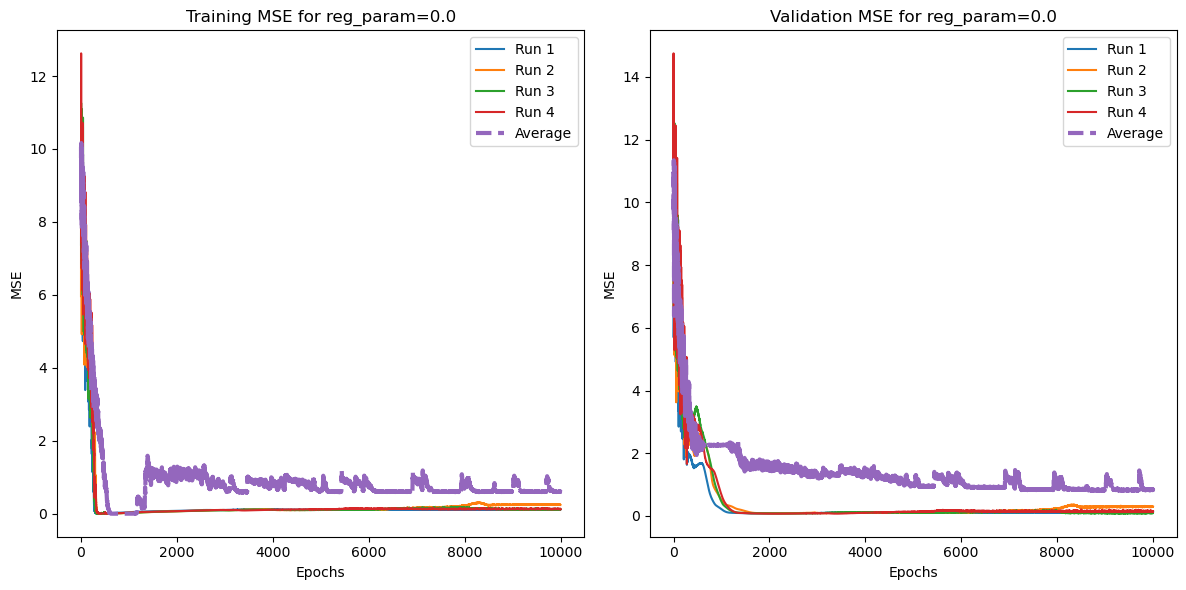

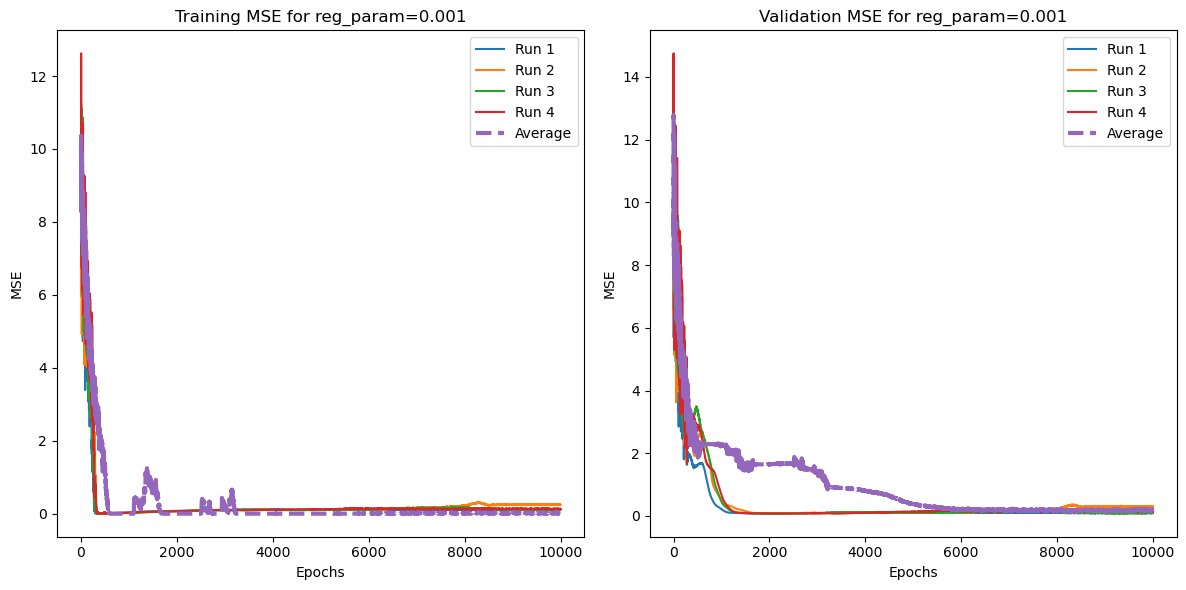

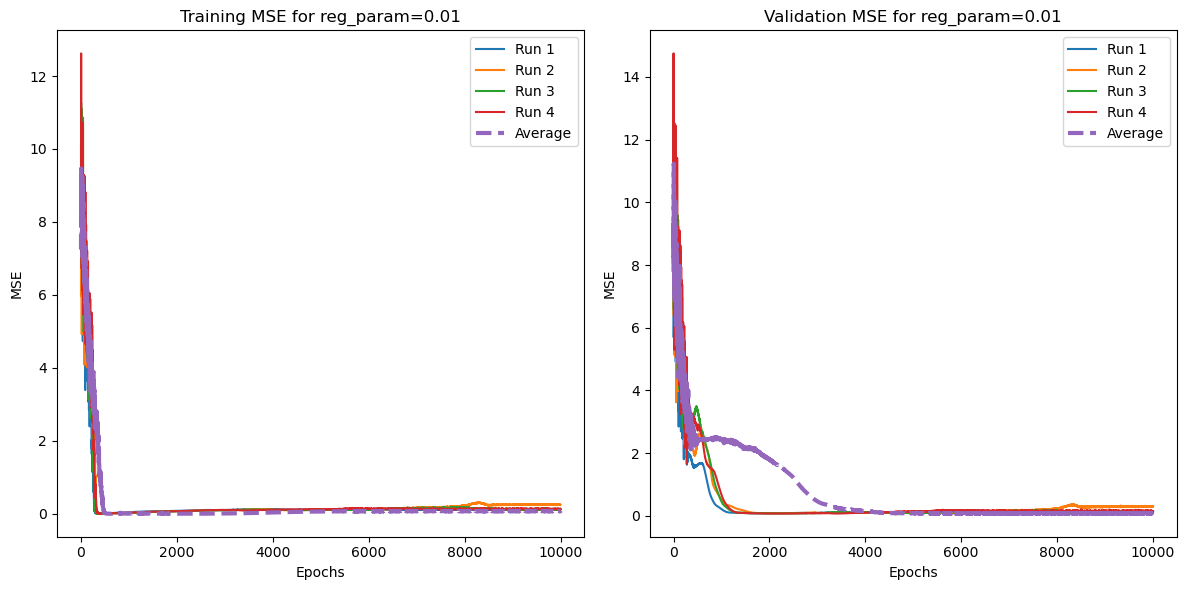

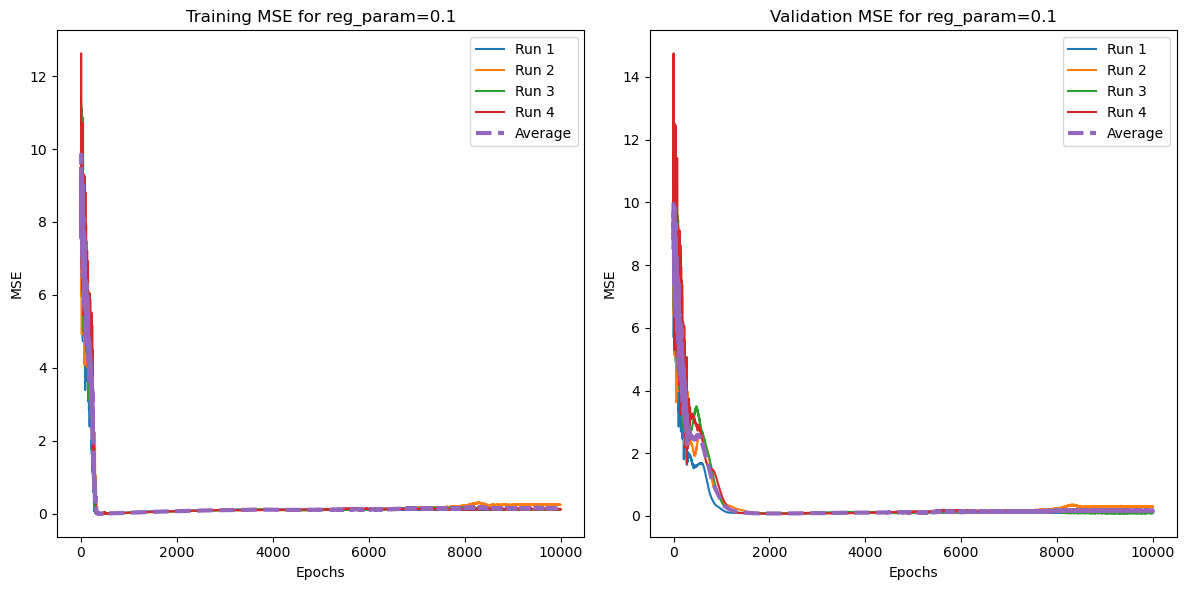

In [19]:
# plot MSE of train and val
for reg_param in regularization_params:
    plt.figure(figsize=(12, 6))

    # train
    plt.subplot(1, 2, 1)
    for run in range(4):
        plt.plot(train_mse_per_run[run], label=f'Run {run+1}')
    plt.plot(train_mse_history[reg_param], label='Average', linewidth=3, linestyle='--')
    plt.title(f'Training MSE for reg_param={reg_param}')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()

    # val
    plt.subplot(1, 2, 2)
    for run in range(4):
        plt.plot(val_mse_per_run[run], label=f'Run {run+1}')
    plt.plot(val_mse_history[reg_param], label='Average', linewidth=3, linestyle='--')
    plt.title(f'Validation MSE for reg_param={reg_param}')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# (b) report average value at final epoch

In [21]:
# (b) print MSE for each reg_param
for reg_param in regularization_params:
    final_train_mse = train_mse_history[reg_param][-1]
    final_val_mse = val_mse_history[reg_param][-1]
    print(f"Final MSE for reg_param={reg_param}: Train MSE={final_train_mse:.6f}, Val MSE={final_val_mse:.6f}")

# which one is best
optimal_reg_param = min(regularization_params, key=lambda reg: val_mse_history[reg][-1])
print(f"Optimal regularization parameter: {optimal_reg_param}")

Final MSE for reg_param=0.0: Train MSE=0.599108, Val MSE=0.854393
Final MSE for reg_param=0.001: Train MSE=0.010080, Val MSE=0.197851
Final MSE for reg_param=0.01: Train MSE=0.073449, Val MSE=0.085316
Final MSE for reg_param=0.1: Train MSE=0.150882, Val MSE=0.173129
Optimal regularization parameter: 0.01


# (c) evaluate the prediction

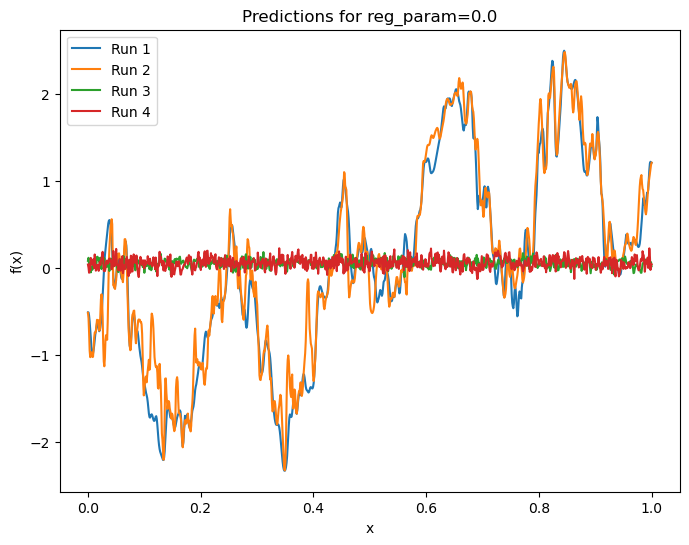

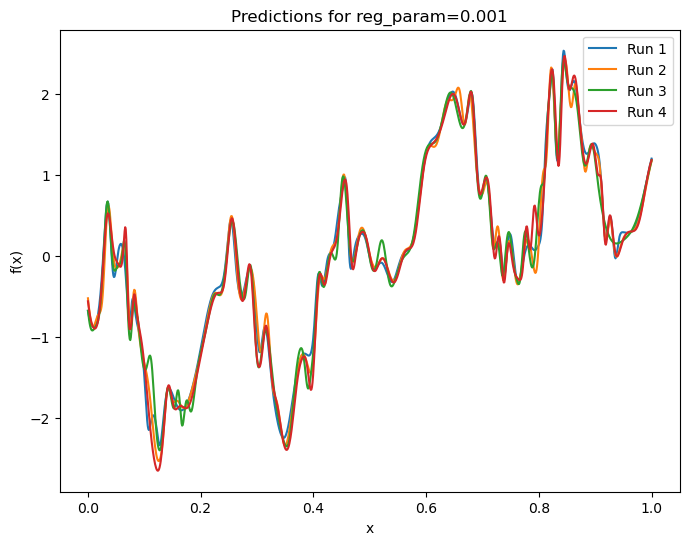

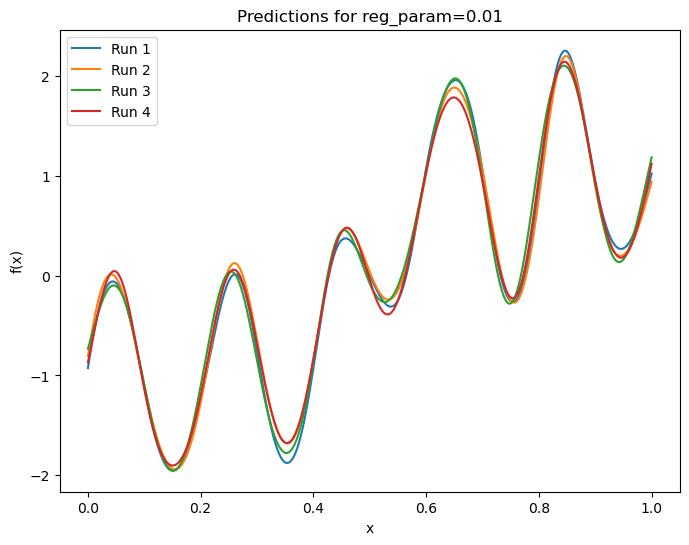

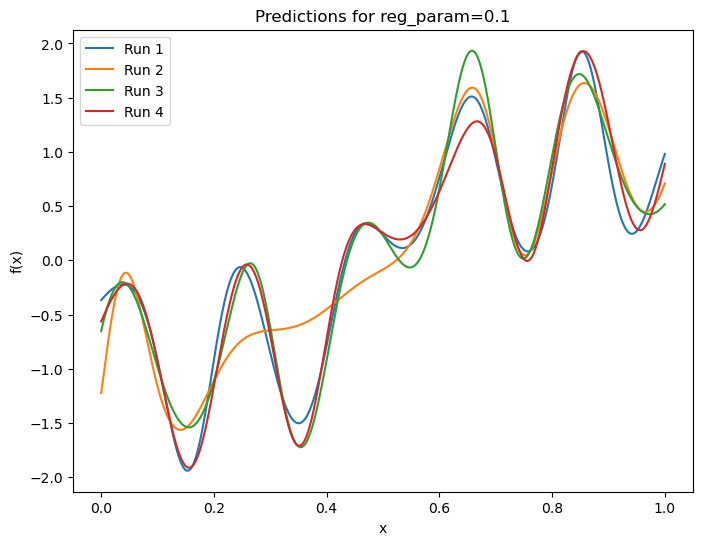

In [23]:
# plot predict
for reg_idx, reg_param in enumerate(regularization_params):
    plt.figure(figsize=(8, 6))
    plt.title(f'Predictions for reg_param={reg_param}')
    plt.xlabel('x')
    plt.ylabel('f(x)')

    # one plot 4 runs
    for run in range(4):
        plt.plot(test_points.numpy(), predictions_history[reg_idx][run], label=f'Run {run+1}')

    plt.legend()
    plt.show()


# Explain the effect of regularization on these predictions.
Regularization is used to reduce the phenomenon of overfitting, and the size of the regularization parameter determines the weight of the penalty term. 

Smaller regularization parameters (0 and 1e-3) mean a smaller penalty, which may result in overfitting. 
Larger regularization parameters (1e-1) focus more on simplifying the model to prevent overfitting, but if the regularization is too strong, the model might underfit, meaning it cannot sufficiently fit the training data, leading to increased errors in both the training and validation sets.

# Which regularization parameter yields prediction curves that are closest to the noise-free target function.
The 3rd one, 1e-2 is the best.
As the plots show, 0 and 1e-3 lead to overfitting, and 1e-1 lead to underfitting.